<a href="https://colab.research.google.com/github/R267/Marchenko-lab5/blob/main/task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

house_prices_advanced_regression_techniques_path = kagglehub.competition_download('house-prices-advanced-regression-techniques')

print('Data source import complete.')


100%|██████████| 199k/199k [00:00<00:00, 57.6MB/s]

Extracting files...
Data source import complete.


**Introduction**

This kernel is an attempt to use every trick in the books to unleash the full power of Linear Regression, including a lot of preprocessing and a look at several Regularization algorithms.

At the time of writing, it achieves a score of about 0.121 on the public LB, just using regression, no RF, no xgboost, no ensembling etc. All comments/corrections are more than welcome.

In [4]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
#njobs = 4

In [22]:
# Get data
train = pd.read_csv("/content/sample_data/california_housing_train.csv")
print("train : " + str(train.shape))  # Check for duplicates
print(train.columns)


train : (17000, 9)
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')


In [23]:
# Check for duplicate rows based on all columns
duplicates = train.duplicated().sum()
print(f"There are {duplicates} duplicate rows in the dataset.")

# Drop duplicate rows if any
train = train.drop_duplicates()

# Check the shape after dropping duplicates
print("train after dropping duplicates: " + str(train.shape))


There are 0 duplicate rows in the dataset.
train after dropping duplicates: (17000, 9)


**Preprocessing**

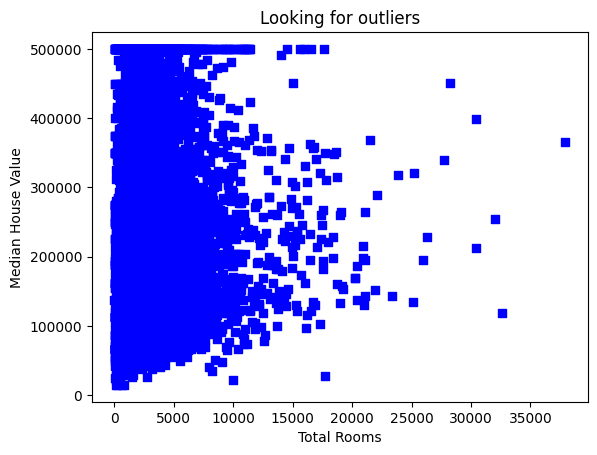

In [25]:
import matplotlib.pyplot as plt

# Looking for outliers between 'total_rooms' and 'median_house_value'
plt.scatter(train.total_rooms, train.median_house_value, c="blue", marker="s")
plt.title("Looking for outliers")
plt.xlabel("Total Rooms")
plt.ylabel("Median House Value")
plt.show()

# You can filter out outliers if necessary (for example, values of 'total_rooms' greater than 4000)
train = train[train.total_rooms < 4000]


There seems to be 2 extreme outliers on the bottom right, really large houses that sold for really cheap. More generally, the author of the dataset recommends removing 'any houses with more than 4000 square feet' from the dataset.  
Reference : https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

In [27]:
import numpy as np

# Логарифмічна трансформація для 'median_house_value'
train['median_house_value'] = np.log1p(train['median_house_value'])

# Тепер ви можете використовувати цей стовпець як цільову змінну
y = train['median_house_value']


<ipython-input-27-2606a8df21d3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['median_house_value'] = np.log1p(train['median_house_value'])


Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.

In [29]:
# Handle missing values for features where median/mean or most common value doesn't make sense

# Alley : data description says NA means "no alley access"
# Оскільки у вас немає деяких колонок, просто обробимо відсутні значення для тих, що є:
train['total_rooms'] = train['total_rooms'].fillna(0)
train['total_bedrooms'] = train['total_bedrooms'].fillna(0)
train['population'] = train['population'].fillna(0)
train['households'] = train['households'].fillna(0)
train['median_income'] = train['median_income'].fillna(train['median_income'].mean())  # використати середнє значення
train['median_house_value'] = train['median_house_value'].fillna(train['median_house_value'].mean())  # середнє значення

# Для колонок 'longitude' та 'latitude' можна зробити так, якщо є пропуски:
train['longitude'] = train['longitude'].fillna(train['longitude'].mean())
train['latitude'] = train['latitude'].fillna(train['latitude'].mean())


<ipython-input-29-04cd998587cf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['total_rooms'] = train['total_rooms'].fillna(0)
<ipython-input-29-04cd998587cf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['total_bedrooms'] = train['total_bedrooms'].fillna(0)
<ipython-input-29-04cd998587cf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [30]:
# Some numerical features are actually really categories
train = train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45",
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75",
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120",
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [31]:
# Encode some categorical features as ordered numbers when there is information in the order
train = train.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4,
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4,
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5,
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

Then we will create new features, in 3 ways :

 1. Simplifications of existing features
 2. Combinations of existing features
 3. Polynomials on the top 10 existing features

In [33]:
import pandas as pd
import numpy as np

# Припустимо, що train - це ваш DataFrame
# Ось список наявних колонок:
# 'longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
# 'population', 'households', 'median_income', 'median_house_value'

# 1. Створення нових ознак:

# 1* Спрощення існуючих ознак (якщо є логіка для цього)
# (Немає конкретних колонок для цього, тому ми можемо пропустити)

# 2* Комбінації існуючих ознак:

# Загальна площа для кімнат на одну спальню
train["RoomsPerBedroom"] = train["total_rooms"] / train["total_bedrooms"]

# Середня площа на домогосподарство
train["RoomsPerHousehold"] = train["total_rooms"] / train["households"]

# Площа на людину
train["RoomsPerPerson"] = train["total_rooms"] / train["population"]

# Площа на домогосподарство для спалень
train["BedroomsPerHousehold"] = train["total_bedrooms"] / train["households"]

# Відношення середнього доходу до середньої вартості будинку
train["IncomeToHouseValue"] = train["median_income"] / train["median_house_value"]

# Вік будинку
train["HouseAge"] = train["housing_median_age"]

# 3* Змішані комбінації кількох змінних
# Наприклад, можна поєднати доходи, площу та кількість кімнат для оцінки загального стану:
train["IncomePerRoom"] = train["median_income"] / train["total_rooms"]

# Відношення кількості людей до кількості домогосподарств
train["PeoplePerHousehold"] = train["population"] / train["households"]

# Відношення площі до кількості спалень
train["AreaPerBedroom"] = train["total_rooms"] / train["total_bedrooms"]

# 4* Показники на основі географічного розташування
# Для цього можна створити додаткові ознаки, якщо необхідно

# Перевірка на результат
print(train.head())


   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
2   -114.560    33.690              17.000      720.000         174.000   
3   -114.570    33.640              14.000     1501.000         337.000   
4   -114.570    33.570              20.000     1454.000         326.000   
5   -114.580    33.630              29.000     1387.000         236.000   
6   -114.580    33.610              25.000     2907.000         680.000   

   population  households  median_income  median_house_value  RoomsPerBedroom  \
2     333.000     117.000          1.651              11.359            4.138   
3     515.000     226.000          3.192              11.204            4.454   
4     624.000     262.000          1.925              11.090            4.460   
5     671.000     239.000          3.344              11.212            5.877   
6    1841.000     633.000          2.677              11.319            4.275   

   RoomsPerHousehold  RoomsPerPerson  BedroomsPerHousehold  \


In [35]:
# Перевірка на наявність стовпця 'median_house_value' в наборі даних
print(train.columns)

# Перевірка на наявність пропущених значень
print(train.isnull().sum())

# Якщо пропущені значення є, їх можна заповнити або видалити перед обчисленням кореляції
train = train.fillna(train.mean())  # Наприклад, заповнити пропущені значення середнім

# Обчислення кореляцій між ознаками
corr = train.corr()

# Сортування ознак по кореляції з цільовою змінною (в цьому випадку 'median_house_value')
corr.sort_values(["median_house_value"], ascending=False, inplace=True)

# Виведення найбільш важливих ознак відносно цільової змінної
print(corr["median_house_value"])


Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'RoomsPerBedroom', 'RoomsPerHousehold',
       'RoomsPerPerson', 'BedroomsPerHousehold', 'IncomeToHouseValue',
       'HouseAge', 'IncomePerRoom', 'PeoplePerHousehold', 'AreaPerBedroom'],
      dtype='object')
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms          0
population              0
households              0
median_income           0
median_house_value      0
RoomsPerBedroom         0
RoomsPerHousehold       0
RoomsPerPerson          0
BedroomsPerHousehold    0
IncomeToHouseValue      0
HouseAge                0
IncomePerRoom           0
PeoplePerHousehold      0
AreaPerBedroom          0
dtype: int64
median_house_value      1.000
median_income           0.652
IncomeToHouseValue      0.606
RoomsPerBedroom         0.347
AreaPerBedroom       

In [40]:
# Перевірка доступних стовпців в даних
print(train.columns)

# Оновлені змінні з наявних стовпців
train["total_rooms-2"] = train["total_rooms"] ** 2
train["total_rooms-3"] = train["total_rooms"] ** 3
train["total_rooms-Sq"] = np.sqrt(train["total_rooms"])

train["total_bedrooms-2"] = train["total_bedrooms"] ** 2
train["total_bedrooms-3"] = train["total_bedrooms"] ** 3
train["total_bedrooms-Sq"] = np.sqrt(train["total_bedrooms"])

train["population-2"] = train["population"] ** 2
train["population-3"] = train["population"] ** 3
train["population-Sq"] = np.sqrt(train["population"])

train["households-2"] = train["households"] ** 2
train["households-3"] = train["households"] ** 3
train["households-Sq"] = np.sqrt(train["households"])

train["median_income-2"] = train["median_income"] ** 2
train["median_income-3"] = train["median_income"] ** 3
train["median_income-Sq"] = np.sqrt(train["median_income"])

train["median_house_value-2"] = train["median_house_value"] ** 2
train["median_house_value-3"] = train["median_house_value"] ** 3
train["median_house_value-Sq"] = np.sqrt(train["median_house_value"])

# Виведення результату
print(train.head())


Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'RoomsPerBedroom', 'RoomsPerHousehold',
       'RoomsPerPerson', 'BedroomsPerHousehold', 'IncomeToHouseValue',
       'HouseAge', 'IncomePerRoom', 'PeoplePerHousehold', 'AreaPerBedroom',
       'total_rooms-2', 'total_rooms-3', 'total_rooms-Sq', 'total_bedrooms-2',
       'total_bedrooms-3', 'total_bedrooms-Sq', 'population-2', 'population-3',
       'population-Sq', 'households-2', 'households-3', 'households-Sq',
       'median_income-2', 'median_income-3', 'median_income-Sq',
       'median_house_value-2', 'median_house_value-3',
       'median_house_value-Sq'],
      dtype='object')
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
2   -114.560    33.690              17.000      720.000         174.000   
3   -114.570    33.640              14.000     1501.000         337.000   
4   -114.570 

In [42]:
# Перевірка доступних стовпців у наборі даних
print(train.columns)

# Якщо стовпець 'SalePrice' існує, видаляємо його з числових ознак
if 'SalePrice' in train.columns:
    numerical_features = numerical_features.drop("SalePrice")
else:
    print("'SalePrice' не знайдено в даних")

# Виведення результатів
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))

# Створення окремих DataFrame для числових та категоріальних ознак
train_num = train[numerical_features]
train_cat = train[categorical_features]


Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'RoomsPerBedroom', 'RoomsPerHousehold',
       'RoomsPerPerson', 'BedroomsPerHousehold', 'IncomeToHouseValue',
       'HouseAge', 'IncomePerRoom', 'PeoplePerHousehold', 'AreaPerBedroom',
       'total_rooms-2', 'total_rooms-3', 'total_rooms-Sq', 'total_bedrooms-2',
       'total_bedrooms-3', 'total_bedrooms-Sq', 'population-2', 'population-3',
       'population-Sq', 'households-2', 'households-3', 'households-Sq',
       'median_income-2', 'median_income-3', 'median_income-Sq',
       'median_house_value-2', 'median_house_value-3',
       'median_house_value-Sq'],
      dtype='object')
'SalePrice' не знайдено в даних
Numerical features : 36
Categorical features : 0


In [43]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 0
Remaining NAs for numerical features in train : 0


In [44]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

22 skewed numerical features to log transform


In [47]:
# Перевірка наявності категоріальних ознак
print("Категоріальні стовпці: ", categorical_features)

# Перевірка, чи містить train_cat дані
if not train_cat.empty:
    print("NAs для категоріальних ознак у train : " + str(train_cat.isnull().values.sum()))
    train_cat = pd.get_dummies(train_cat)
    print("Залишкові NAs для категоріальних ознак у train : " + str(train_cat.isnull().values.sum()))
else:
    print("train_cat порожній, перевірте категоріальні стовпці")



Категоріальні стовпці:  Index([], dtype='object')
train_cat порожній, перевірте категоріальні стовпці


**Modeling**

In [48]:
# Join categorical and numerical features
train = pd.concat([train_num, train_cat], axis = 1)
print("New number of features : " + str(train.shape[1]))

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

New number of features : 36
X_train : (10176, 36)
X_test : (4362, 36)
y_train : (10176,)
y_test : (4362,)


In [49]:
# Standardize numerical features
stdSc = StandardScaler()
X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

Standardization cannot be done before  the partitioning, as we don't want to fit the StandardScaler on some observations that will later be used in the test set.

In [50]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

Note : I'm not getting nearly the same numbers in local CV compared to public LB, so I'm a tad worried that my CV process may have an issue somewhere. If you spot something, please let me know.

**1* Linear Regression without regularization**

RMSE on Training set : 1.4794950043857215e-15
RMSE on Test set : 2.180066291802719e-15


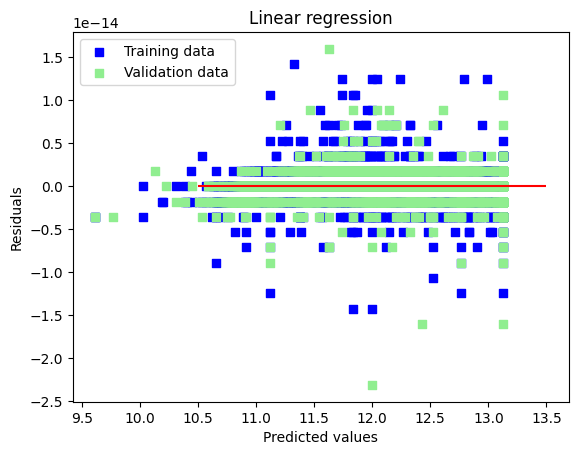

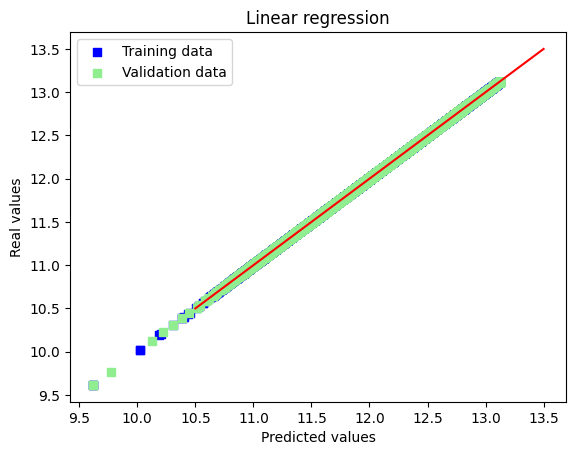

In [51]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

RMSE on Training set shows up weird here (not when I run it on my computer) for some reason.  
Errors seem randomly distributed and randomly scattered around the centerline, so there is that at least. It means our model was able to capture most of the explanatory information.

**2* Linear Regression with Ridge regularization (L2 penalty)**

From the *Python Machine Learning* book by Sebastian Raschka :  Regularization is a very useful method to handle collinearity, filter out noise from data, and eventually prevent overfitting. The concept behind regularization is to introduce additional information (bias) to penalize extreme parameter weights.  

Ridge regression is an L2 penalized model where we simply add the squared sum of the weights to our cost function.

Best alpha : 0.01
Try again for more precision with alphas centered around 0.01
Best alpha : 0.006
Ridge RMSE on Training set : 6.928283546248356e-05
Ridge RMSE on Test set : 0.00010317513398356707


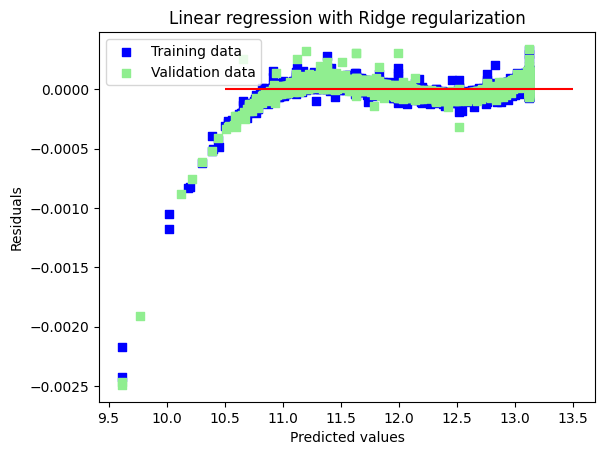

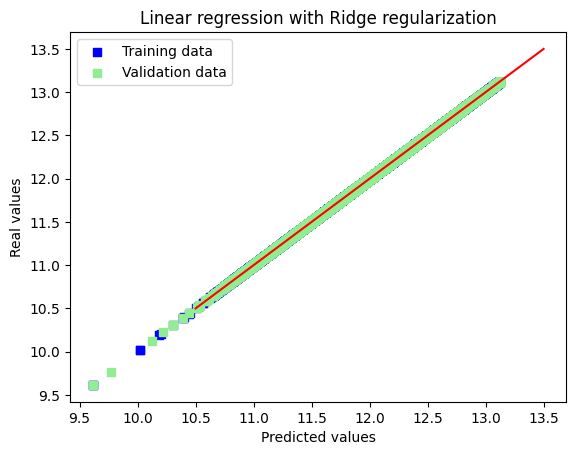

Ridge picked 36 features and eliminated the other 0 features


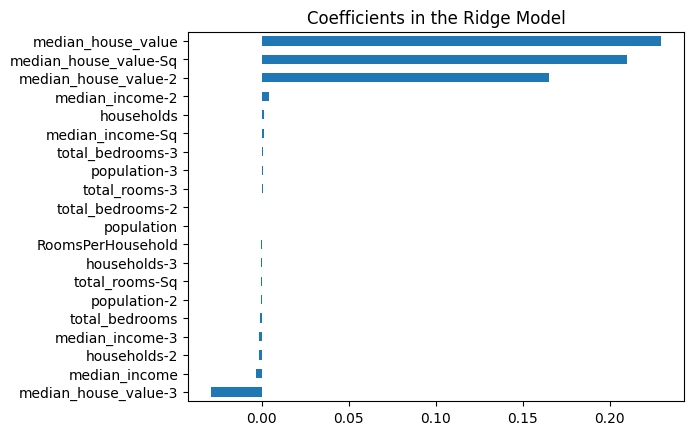

In [52]:
# 2* Ridge
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85,
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4],
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

We're getting a much better RMSE result now that we've added regularization. The very small difference between training and test results indicate that we eliminated most of the overfitting. Visually, the graphs seem to confirm that idea.  

Ridge used almost all of the existing features.

**3* Linear Regression with Lasso regularization (L1 penalty)**

LASSO stands for *Least Absolute Shrinkage and Selection Operator*. It is an alternative regularization method, where we simply replace the square of the weights by the sum of the absolute value of the weights. In contrast to L2 regularization, L1 regularization yields sparse feature vectors : most feature weights will be zero. Sparsity can be useful in practice if we have a high dimensional dataset with many features that are irrelevant.  

We can suspect that it should be more efficient than Ridge here.

Best alpha : 0.0001
Try again for more precision with alphas centered around 0.0001
Best alpha : 6e-05
Lasso RMSE on Training set : 0.0003959637154322405
Lasso RMSE on Test set : 0.00039908054237488806


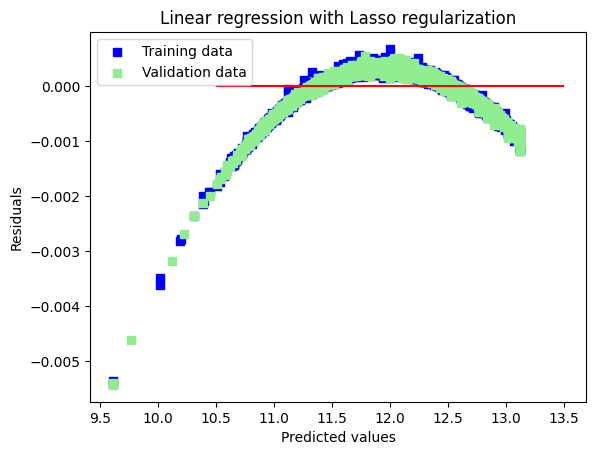

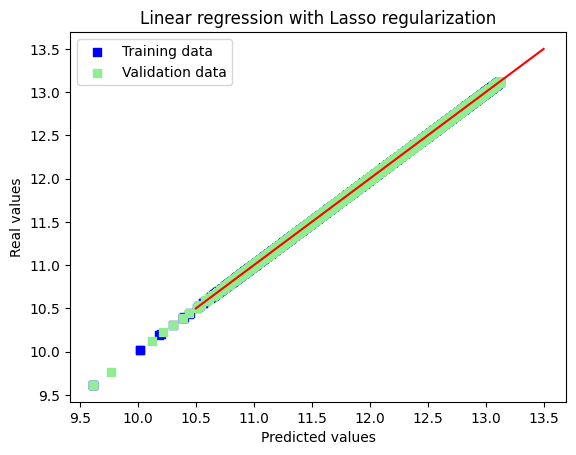

Lasso picked 6 features and eliminated the other 30 features


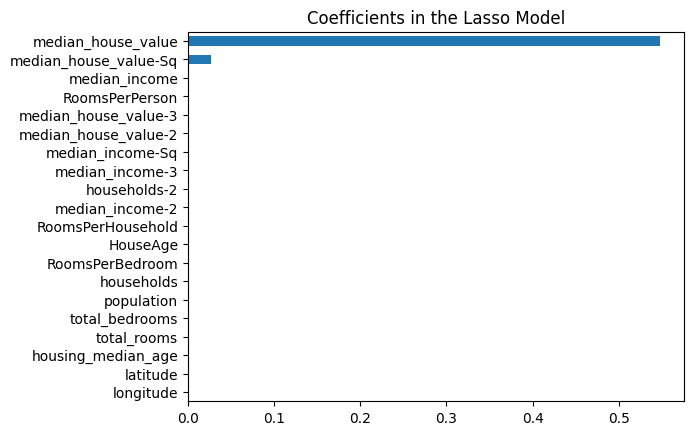

In [53]:
# 3* Lasso
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
                          0.3, 0.6, 1],
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8,
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05,
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35,
                          alpha * 1.4],
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

RMSE results are better both on training and test sets. The most interesting thing is that Lasso used only one third of the available features. Another interesting tidbit : it seems to give big weights to Neighborhood categories, both in positive and negative ways. Intuitively it makes sense, house prices change a whole lot from one neighborhood to another in the same city.  

The "MSZoning_C (all)" feature seems to have a disproportionate impact compared to the others. It is defined as *general zoning classification : commercial*. It seems a bit weird to me that having your house in a mostly commercial zone would be such a terrible thing.

**4* Linear Regression with ElasticNet regularization (L1 and L2 penalty)**

ElasticNet is a compromise between Ridge and Lasso regression. It has a L1 penalty to generate sparsity and a L2 penalty to overcome some of the limitations of Lasso, such as the number of variables (Lasso can't select more features than it has observations, but it's not the case here anyway).

Best l1_ratio : 1.0
Best alpha : 0.0001
Try again for more precision with l1_ratio centered around 1.0
Best l1_ratio : 1.0
Best alpha : 0.0001
Now try again for more precision on alpha, with l1_ratio fixed at 1.0 and alpha centered around 0.0001
Best l1_ratio : 1.0
Best alpha : 6e-05
ElasticNet RMSE on Training set : 0.0003959637154322405
ElasticNet RMSE on Test set : 0.00039908054237488806


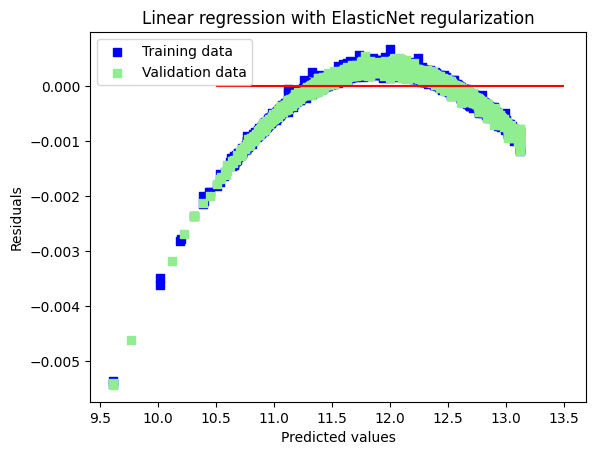

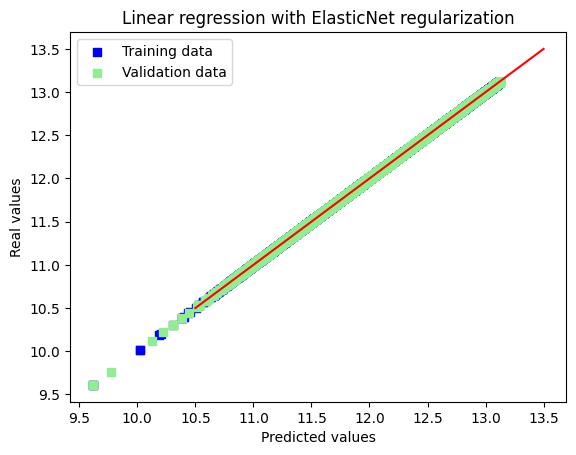

ElasticNet picked 6 features and eliminated the other 30 features


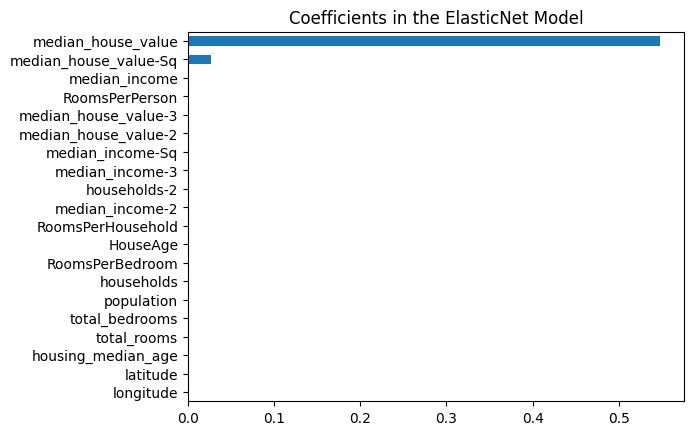

In [54]:
# 4* ElasticNet
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006,
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6],
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6],
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) +
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9,
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3,
                                    alpha * 1.35, alpha * 1.4],
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())
y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

The optimal L1 ratio used by ElasticNet here is equal to 1, which means it is exactly equal to the Lasso regressor we used earlier (and had it been equal to 0, it would have been exactly equal to our Ridge regressor). The model didn't need any L2 regularization to overcome any potential L1 shortcoming.

Note : I tried to remove the "MSZoning_C (all)" feature, it resulted in a slightly worse CV score, but slightly better public LB score.

**Conclusion**  

Putting time and effort into preparing the dataset and optimizing the regularization resulted in a decent score, better than some public scripts which use algorithms that historically perform better in Kaggle contests, like Random Forests. Being fairly new to the world of machine learning contests, I will appreciate any constructive pointer to improve, and I thank you for your time.